In [2]:
import requests
import pandas as pd
import numpy as np
import json
from datetime import datetime
import time
import os
from dotenv import load_dotenv
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from functools import reduce

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import  RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")



In [3]:
df_income = pd.read_csv('data/income_statement.csv')
df_balance = pd.read_csv('data/balance_sheet.csv')
df_cash_flow = pd.read_csv('data/cash_flow_statement.csv')   
df_earnings = pd.read_csv('data/earnings.csv')   
df_overview = pd.read_csv('data/company_overview.csv')

In [4]:
df_technical = pd.read_csv('data/technical_data.csv')

In [5]:
df_price = pd.read_csv('data/tech_stock_daily_price.csv')

In [6]:
df_income['fiscalDateEnding'] = pd.to_datetime(df_income['fiscalDateEnding'])
df_balance['fiscalDateEnding'] = pd.to_datetime(df_balance['fiscalDateEnding'])
df_cash_flow['fiscalDateEnding'] = pd.to_datetime(df_cash_flow['fiscalDateEnding'])
df_earnings['fiscalDateEnding'] = pd.to_datetime(df_earnings['fiscalDateEnding'])
df_technical['date'] = pd.to_datetime(df_technical['date'])
df_price['Date'] = pd.to_datetime(df_price['Date'])

In [7]:
df_earnings = df_earnings[df_earnings['fiscalDateEnding'] >= '2005-01-01']
df_technical = df_technical[df_technical['date']>='2005-01-01']
df_price = df_price[df_price['Date'] >= '2005-01-01']

In [8]:
df_income = df_income.sort_values(by=['symbol', 'fiscalDateEnding'])
df_balance = df_balance.sort_values(by=['symbol', 'fiscalDateEnding'])
df_cash_flow = df_cash_flow.sort_values(by=['symbol', 'fiscalDateEnding'])
df_earnings = df_earnings.sort_values(by=['symbol', 'fiscalDateEnding'])
df_technical = df_technical.sort_values(by=['ticker', 'date'])
df_price = df_price.sort_values(by=['ticker', 'Date'])

In [9]:
symbol= 'AAPL'  # Example symbol, replace with your desired stock symbol

In [10]:

income_data = df_income[df_income['symbol'] == symbol]
balance_data = df_balance[df_balance['symbol'] == symbol]
overview_data = df_overview[df_overview['symbol'] == symbol]
earnings_data = df_earnings[df_earnings['symbol'] == symbol]
cash_flow_data = df_cash_flow[df_cash_flow['symbol'] == symbol]
technical_data = df_technical[df_technical['ticker']==symbol]
price_data = df_price[df_price['ticker'] == symbol]

In [11]:
income_data = income_data.drop(columns=['symbol','reportedCurrency'])

In [12]:
all_nan_columns = income_data.columns[income_data.isna().all()].tolist()

In [13]:
income_data = income_data.drop(columns=all_nan_columns)

In [14]:
balance_data = balance_data.drop(columns=['symbol','reportedCurrency'])

In [15]:
all_nan_columns = balance_data.columns[balance_data.isna().all()].tolist()

In [16]:
balance_data = balance_data.drop(columns=all_nan_columns)

In [17]:
cash_flow_data = cash_flow_data[['fiscalDateEnding','operatingCashflow']]

In [18]:
earnings_data = earnings_data[['fiscalDateEnding','reportedEPS']]

In [19]:
earnings_data

,fiscalDateEnding,reportedEPS
80,2005-03-31,0.01
79,2005-06-30,0.01
78,2005-09-30,0.02
77,2005-12-31,0.02
76,2006-03-31,0.02
...,...,...
4,2024-03-31,1.53
3,2024-06-30,1.40
2,2024-09-30,0.97
1,2024-12-31,2.40


In [20]:
merged_df = reduce(lambda left, right: pd.merge(left, right, on='fiscalDateEnding'), [income_data, balance_data, cash_flow_data, earnings_data])

In [21]:
merged_df = merged_df.sort_values(by='fiscalDateEnding')

In [22]:
df = merged_df.merge(technical_data, left_on='fiscalDateEnding',right_on='date')

In [23]:
df = price_data[['Date','Close']].merge(df, right_on='fiscalDateEnding', left_on='Date', how='left')

In [24]:
df = df.fillna(method='ffill')

In [25]:
df['Return'] = df['Close'].pct_change().fillna(0)

In [26]:
df['Direction'] = df['Return'].apply(lambda x: 1 if x > 0 else 0)

In [27]:
df = df[df['Date']>='2005-04-01']

In [28]:
### Exclude Outliers
# df = df[(np.abs(df['Return'] - df['Return'].mean()) <= (3 * df['Return'].std()))]
df = df[df['Date']!='2014-06-09']
df = df[df['Date']!='2020-08-31']
df = df[df['Date']!='2020-09-01']


In [29]:
df = df.drop(columns=['Date', 'date','fiscalDateEnding','ticker','company_name'])

In [30]:
df = df.fillna(0)

In [31]:
df_X = df.drop(columns=['Close','Return','Direction'])

In [32]:
df_Y = df['Return']

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    df_X, df_Y, test_size=0.2, random_state=32
)

# 5. Initialize and fit the Random Forest model
rf = RandomForestRegressor(
    n_estimators=100,  # Number of trees
    max_depth=None,    # Let trees expand until all leaves are pure
    random_state=42
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)



In [43]:
import numpy as np
import matplotlib.pyplot as plt


# Indices for plotting
train_idx = range(len(y_train))
test_idx = range(len(y_train), len(y_train) + len(y_test))


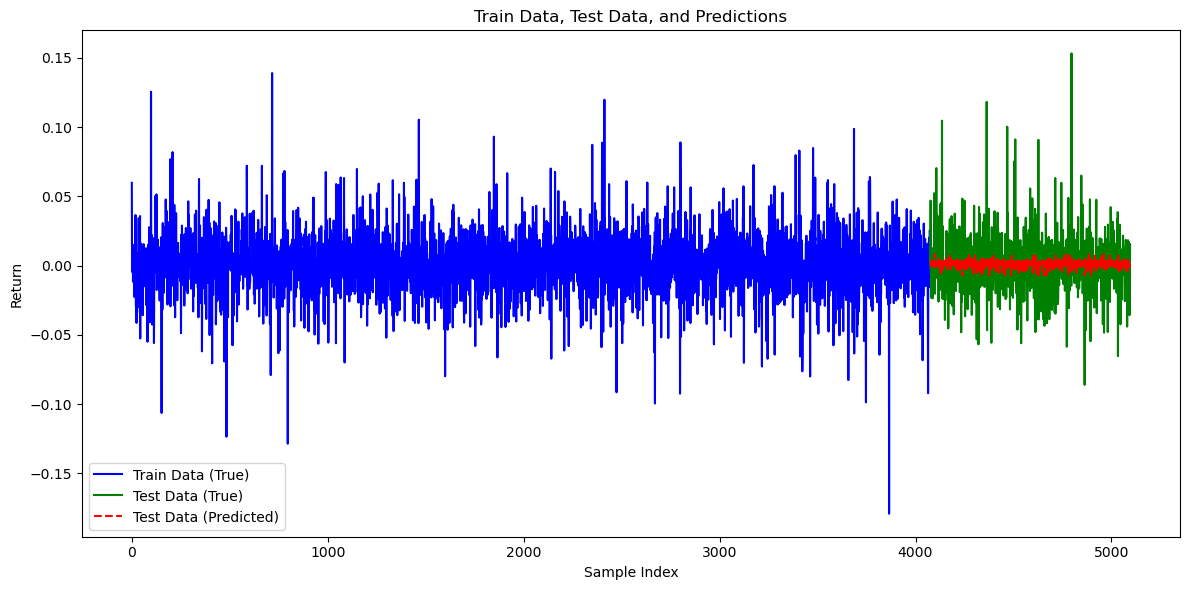

In [46]:
plt.figure(figsize=(12, 6))

# Plot true values for train and test
plt.plot(train_idx, y_train, label='Train Data (True)', color='blue')
plt.plot(test_idx, y_test, label='Test Data (True)', color='green')

# Plot predictions for test set
plt.plot(test_idx, y_pred, label='Test Data (Predicted)', color='red', linestyle='--')

plt.xlabel('Sample Index')
plt.ylabel('Return')
plt.title('Train Data, Test Data, and Predictions')
plt.legend()
plt.tight_layout()
plt.show()


In [38]:
# 7. Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse:.3f}")
print(f"R^2 Score: {r2:.3f}")

# 8. (Optional) Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'max_features': ['auto', 'sqrt']
}
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
print("Best parameters found:", grid_search.best_params_)

# 9. Feature importance
importances = rf.feature_importances_
for name, importance in zip(df_X.columns, importances):
    print(f"{name}: {importance:.3f}")


Root Mean Squared Error: 0.020
R^2 Score: -0.015
Best parameters found: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 100}
grossProfit: 0.011
totalRevenue: 0.005
costOfRevenue: 0.012
costofGoodsAndServicesSold: 0.004
operatingIncome: 0.002
sellingGeneralAndAdministrative: 0.010
researchAndDevelopment: 0.008
operatingExpenses: 0.008
netInterestIncome: 0.016
interestIncome: 0.005
interestExpense: 0.018
otherNonOperatingIncome: 0.016
depreciationAndAmortization: 0.013
incomeBeforeTax: 0.005
incomeTaxExpense: 0.050
netIncomeFromContinuingOperations: 0.010
ebit: 0.004
ebitda: 0.007
netIncome: 0.005
totalAssets: 0.008
totalCurrentAssets: 0.019
cashAndCashEquivalentsAtCarryingValue: 0.011
cashAndShortTermInvestments: 0.018
inventory: 0.018
currentNetReceivables: 0.031
totalNonCurrentAssets: 0.011
propertyPlantEquipment: 0.007
accumulatedDepreciationAmortizationPPE: 0.000
intangibleAssets: 0.013
intangibleAssetsExcludingGoodwill: 0.007
goodwill: 0.025
longTermInvestments: 0.013
shor